# Introduction

This goal of this project is to analyze biodiversity data from the National Parks Service, particularly around various species observed in different national park locations.

During this project, I will be analyzing, cleaning, and ploting data. Additionally, I will be posing questions and using various data analysis techniques to answer them in a meaningful way.

Here are a few questions this project has sought to answer:
* Which species were spotted the most at each national park?
* Which park has the highest and lowest number of reptiles?
* What category has the most amount of endangered or threatened species?
* Are certain categories of species more likely to be a species of concern, threatened, or endangered?
* How many bat sightings have there been per park?

## Data sources
Both `Observations.csv` and `Species_info.csv` were provided by [Codecademy.com](https://www.codecademy.com/).

# Setup
## Import Python modules
First, import the primary modules that will be used in this project:

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency
import seaborn as sns

## Load data

In [58]:
observations_df = pd.read_csv("observations.csv").rename(columns={"observations": "num_observations"})
species_info_df = pd.read_csv("species_info.csv")

## Data exploration
Let's familiarize ourselves with the data by looking at the first few rows of each Dataframe 

In [59]:
observations_df.head()
species_info_df.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


Now, let's use the `.info()` method to dive deeper into the Dataframes


In [60]:
observations_df.info()
species_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23296 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   scientific_name   23296 non-null  object
 1   park_name         23296 non-null  object
 2   num_observations  23296 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 546.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  192 non-null    object
dtypes: object(4)
memory usage: 182.1+ KB


Finally, we'll continue familiarizing ourselves with the data by looking at unique values in certain columns.


In [61]:
observations_df["scientific_name"].nunique()
species_info_df["category"].unique()

array(['Mammal', 'Bird', 'Reptile', 'Amphibian', 'Fish', 'Vascular Plant',
       'Nonvascular Plant'], dtype=object)

# Data cleaning
Now that we understand more about the data and its structure, let's clean the data so it's ready for analysis.

Let's start by checking for missing data.

In [62]:
observations_df.isnull().sum()
species_info_df.isnull().sum()

category                  0
scientific_name           0
common_names              0
conservation_status    5632
dtype: int64

We can see `species_info_df` has 5632 null values in the `conservation_status` column - let's see what those values are.

In [63]:
species_info_df["conservation_status"].unique()

array([nan, 'Species of Concern', 'Endangered', 'com', 'Threatened',
       'In Recovery'], dtype=object)

We can see that NaN values are assigned to species that are currently not endangered or threatened. According to the [IUCN Red List of Endangered Species](https://www.iucnredlist.org/), these species should be assigned a value of "Least Concern."

In [64]:
species_info_df["conservation_status"] = species_info_df["conservation_status"].fillna('Least Concern')

To make our plots cleaner and save space, let's remove unnecessary words from `park_name`

In [65]:
observations_df["park_name"] = observations_df["park_name"].str.replace(" National Park", "")

Finally, since values in the conservation_status column have ordered categories, we will order them now.

In [66]:
species_info_df["conservation_status"] = pd.Categorical(species_info_df["conservation_status"],
                                                        categories=["Least Concern",
                                                                    "Species of Concern",
                                                                    "In Recovery",
                                                                    "Threatened",
                                                                    "Endangered"], ordered=True)

# Research questions

### Question 1: Which species were spotted the most at each park?
To answer this question, we need to merge our two dataframes

In [67]:
species_observations_df = observations_df.merge(species_info_df, how="outer", on="scientific_name")

Next, we'll group by `park name` and `scientific name`

In [68]:
grouped_park_scientific_name = (species_observations_df.groupby(["park_name", "scientific_name"])["num_observations"]
                                .max().reset_index().sort_values(by="num_observations", ascending=False))

Finally, we'll return the highest value in each park and have our answer.

In [69]:
most_spotted_species_per_park = grouped_park_scientific_name.groupby("park_name").first()
print(most_spotted_species_per_park)

                                       scientific_name  num_observations
park_name                                                               
Bryce                             Valerianella radiata               176
Great Smoky Mountains         Sonchus asper ssp. asper               147
Yellowstone                     Lycopodium tristachyum               321
Yosemite               Ivesia shockleyi var. shockleyi               223


### Question 2: Which park has the highest and lowest number of reptiles?

In [70]:
# Filter Dataframe to reptile records
reptile_species = species_observations_df[species_observations_df["category"] == "Reptile"]

# Group by national parks and sort values
grouped_reptile_observations = reptile_species.groupby("park_name")["num_observations"].sum().sort_values()
print(grouped_reptile_observations)

park_name
Great Smoky Mountains     5841
Bryce                     8141
Yosemite                 11779
Yellowstone              20061
Name: num_observations, dtype: int64


We found that Great Smoky Mountains National Park has the least and Yellowstone National Park has the most observations of reptiles.

Now let's plot our results:

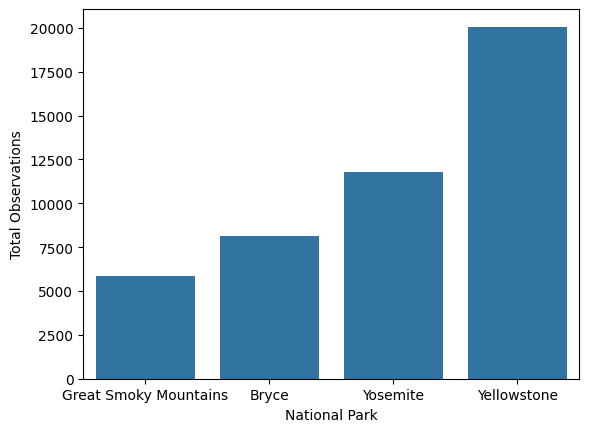

In [71]:
ax = sns.barplot(data=grouped_reptile_observations)
ax.set(xlabel="National Park", ylabel="Total Observations")
plt.show()
plt.close()

### Question 3: What category has the most amount of endangered or threatened species?

In [72]:
# Find rows where conservation status is endangered or threatened
endangered_threatened_species = species_observations_df[(species_observations_df["conservation_status"].isin(["Endangered", "Threatened"]))]

# Count by category
e_t_category_counts = endangered_threatened_species["category"].value_counts(ascending=False)
print(e_t_category_counts)

category
Mammal            52
Fish              32
Bird              16
Amphibian         12
Vascular Plant    12
Name: count, dtype: int64


We found that **mammals** have the most amount of endangered or threatened species.

Now, let's plot our result:

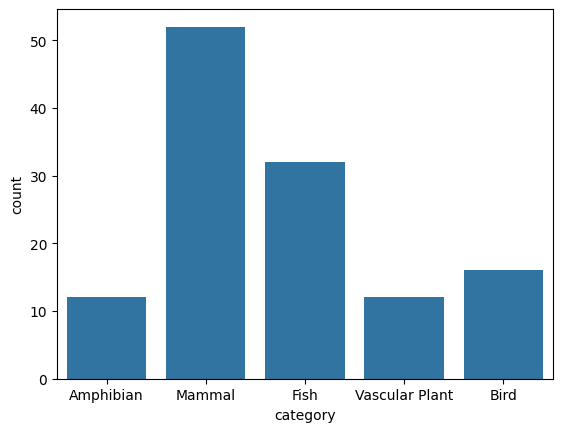

In [73]:
sns.countplot(data=endangered_threatened_species, x="category")
plt.show()
plt.close()

### Question 4: Are certain categories of species more likely to be a species of concern, threatened, or endangered?

In [74]:
# Creating a new column indicating whether a record is protected or not
species_info_df["is_protected"] = (species_info_df["conservation_status"].isin(["Species of Concern", "Threatened", "Endangered"]))

# Group by category
category_counts = species_info_df.groupby(["category", "is_protected"]).scientific_name.nunique().reset_index()

# Pivoting data & renaming columns to be easier to read
category_pivot = category_counts.pivot(columns="is_protected", index="category", values="scientific_name").reset_index()
category_pivot.columns = ["category", "not_protected", "protected"]

# Create contingency table based on data for Chi squared test
# Mammal vs Bird contingency
mammal_bird_contingency = [[30, 147], [72, 416]]
print(chi2_contingency(mammal_bird_contingency))

Chi2ContingencyResult(statistic=np.float64(0.32772967060578273), pvalue=np.float64(0.5669990082889063), dof=1, expected_freq=array([[ 27.14887218, 149.85112782],
       [ 74.85112782, 413.14887218]]))


We can see our **p-value is 0.57**. Given the standard significance threshold of 0.05, the obtained p-valueis much larger. In the case of mammals and birds, there **does not** seem to be any significant relationship between them, indicating that the variables are independent.

Let's see if we'll have better luck with a different category.

In [75]:
# Mammal vs Reptile contingency
mammal_reptile_contingency = [[30, 147], [5, 73]]
print(chi2_contingency(mammal_reptile_contingency))

Chi2ContingencyResult(statistic=np.float64(4.227179070929071), pvalue=np.float64(0.03978150659000946), dof=1, expected_freq=array([[ 24.29411765, 152.70588235],
       [ 10.70588235,  67.29411765]]))


In this case, the **p-value is 0.04** which is below the standard threshold of 0.05. This suggests that the difference between reptiles and mammals **is** statistically significant. Specifically, mammals are shown to have a statistically significant higher rate of needed protection compared to reptiles.

### Question 5: How many bat sightings have there been per park?

In [76]:
# Finding all animals with a commmon name containing, 'bat'
bats = species_observations_df[(species_observations_df["common_names"].str.contains("Bat", regex=True)) & (species_observations_df["category"] == "Mammal")]
bats_grouped = bats.groupby(["park_name"])["num_observations"].sum().reset_index()
print(bats_grouped.sort_values(by="num_observations"))

               park_name  num_observations
1  Great Smoky Mountains              2411
0                  Bryce              3433
3               Yosemite              4786
2            Yellowstone              8362


From the result we can see the breakdown of total bat sightings per park. Based on this data, if someone wants to visit a national park to see bats, Yellowstone is likely the best place for them to go.

# Conclusion
The project was able to make several data visualizations and inferences about the various species in four of the National Parks that comprised this data set.

#### Analysis summary:
**Which species were spotted the most at each park?**
* The most spotted species in Bryce National Park is `Valerianella radiata`.
* The most spotted species in Great Smoky Mountains National Park is `Sonchus asper ssp. asper`.
* The most spotted species in Yellowstone National Park is `Lycopodium tristachyum`.
* The most spotted species in Yosemite National Park is `Ivesia shockleyi var. shockleyi`.

**Which park has the highest and lowest number of observed reptiles?**
* Most: Yellowstone National Park
* Least: Great Smoky Mountains National Park

**What category has the most amount of endangered or threatened species?**
* Mammals have the most amount of endangered or threatened species

**Are certain categories of species more likely to be a species of concern, threatened, or endangered?**
* While mammals and Birds did not have significant difference in conservation percentage, mammals and reptiles exhibited a statistically significant difference.

**How many bat sightings have there been per park?**
* Great Smoky Mountains National Park: 2411
* Bryce National Park: 3433
* Yosemite National Park: 4786
* Yellowstone National Park: 8362